In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

In [22]:
# データセットの読み込み
data = pd.read_csv('./data/concrete_data.csv')



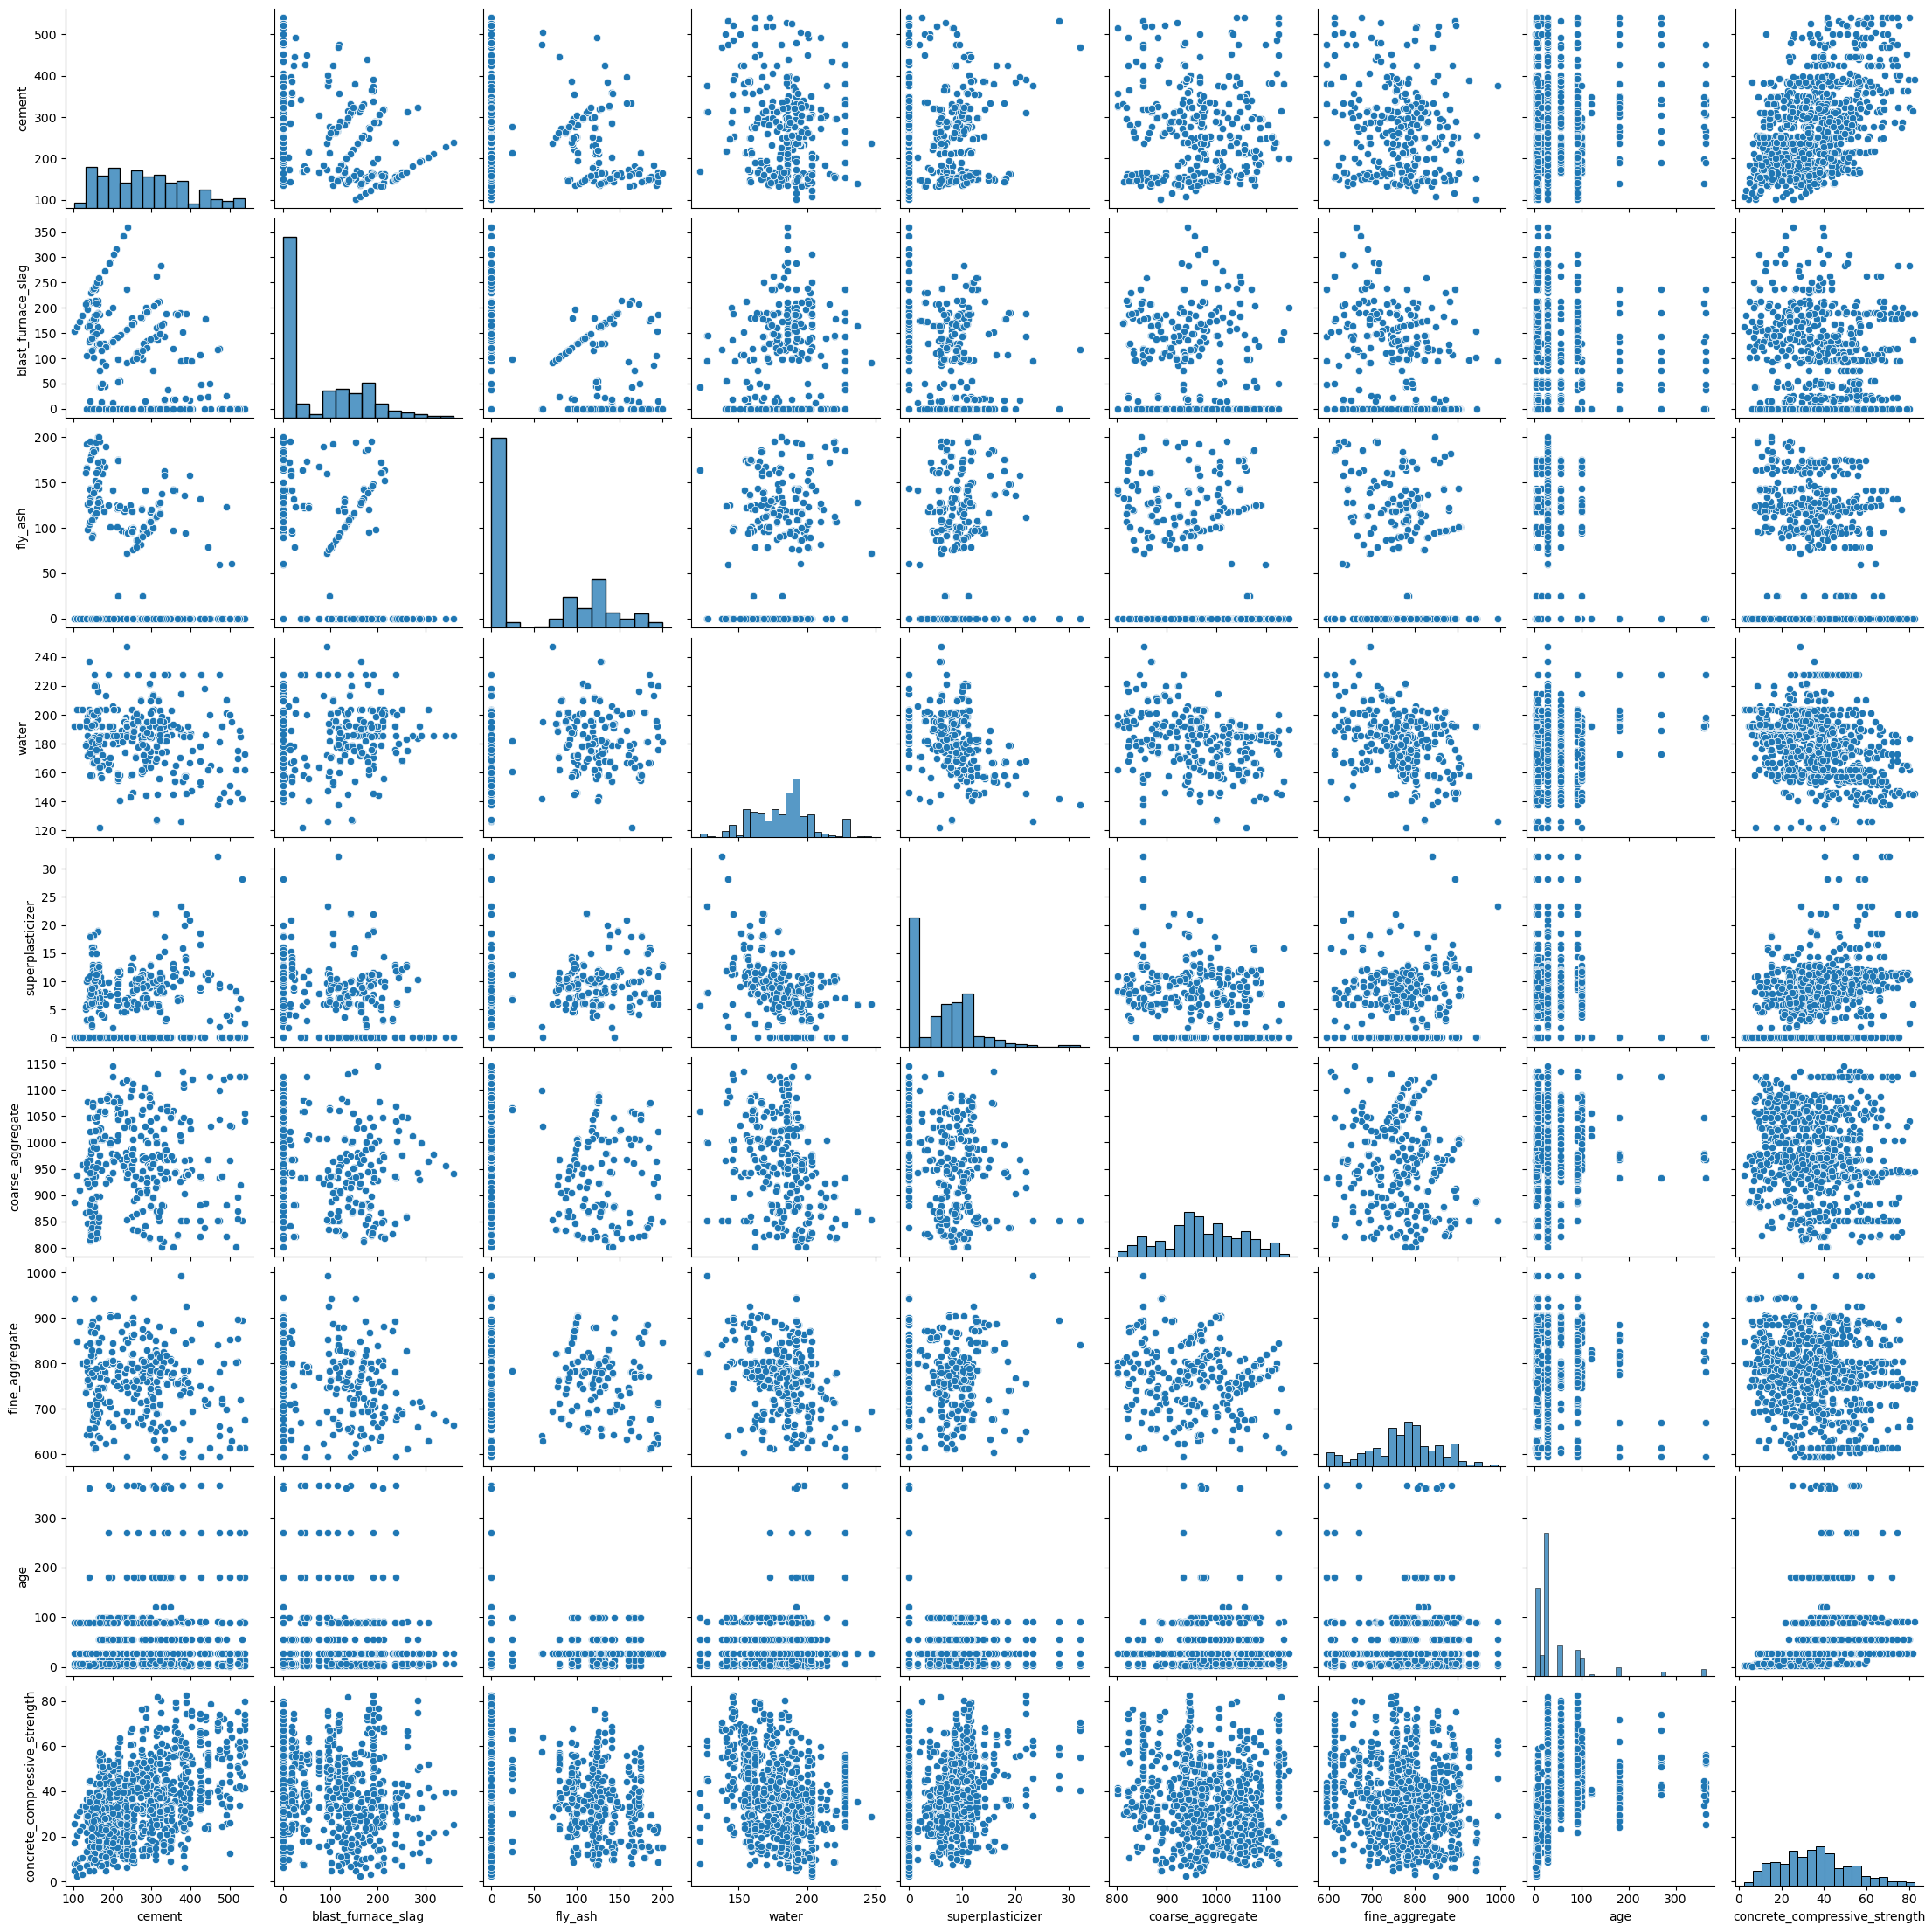

In [23]:
# データの可視化
sns.pairplot(data)
plt.show()

In [24]:
# 特徴量とターゲットの分割
X = data.iloc[:, :-1].values  # 特徴量
y = data.iloc[:, -1].values   # ターゲット（圧縮強度）



In [25]:
# データの標準化
scaler = StandardScaler()
X = scaler.fit_transform(X)



In [26]:
# 訓練データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [27]:
y_test

array([52.91, 55.9 , 74.5 , 35.3 , 10.54, 44.28, 23.69, 45.37, 37.4 ,
       48.85, 25.1 , 10.73, 40.2 , 49.8 , 33.01, 21.92, 40.06, 19.35,
       37.17, 33.09, 31.38, 37.96, 48.72,  6.9 , 38.6 , 30.85, 11.17,
       41.05, 52.96, 13.22, 52.3 , 39.6 , 51.86, 66.42, 14.94, 33.02,
       31.64, 39.42, 13.66, 51.96, 15.58,  6.28, 38.07, 50.24, 10.03,
       63.4 , 55.55, 36.15, 21.75,  4.83, 57.21, 47.78, 29.41, 12.37,
       64.02, 34.4 , 25.37, 13.71, 31.72, 19.77, 39.42, 13.52, 35.34,
       46.8 , 33.  , 18.03, 33.4 , 12.18, 27.66, 24.43, 11.65, 24.05,
        9.31, 25.1 , 26.14, 11.58, 55.26, 60.95, 61.86, 14.59, 44.21,
       34.9 , 41.68, 39.59, 41.05, 35.3 , 44.61, 33.72, 21.5 , 20.08,
       31.65, 75.5 , 15.04, 56.61, 53.52, 50.66, 31.35, 45.71, 19.11,
       32.92, 25.45, 41.94, 36.25, 24.  , 70.7 , 10.34, 56.81, 30.12,
       44.64, 44.52, 44.7 , 51.04, 30.28, 37.34, 38.61, 61.07, 18.13,
       33.76, 61.99, 53.52, 19.77, 26.94, 51.43, 29.98, 21.91, 43.5 ,
       59.76, 49.2 ,

In [28]:
# PyTorchのテンソルに変換
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)



In [29]:
# ニューラルネットワークの定義
class ConcreteStrengthModel(nn.Module):
    def __init__(self):
        super(ConcreteStrengthModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [30]:
# モデルのインスタンス化
model = ConcreteStrengthModel()



In [31]:
# 損失関数とオプティマイザの定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [32]:
# 交差検証の設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
# 学習過程の記録用リスト
train_losses = []
val_losses = []

In [34]:
# モデルの訓練
num_epochs = 1000
best_loss = np.inf
patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    fold_train_losses = []
    fold_val_losses = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        optimizer.zero_grad()
        outputs = model(X_train_fold)
        loss = criterion(outputs, y_train_fold)
        loss.backward()
        optimizer.step()
        
        fold_train_losses.append(loss.item())
        
        model.eval()
        val_outputs = model(X_val_fold)
        val_loss = criterion(val_outputs, y_val_fold)
        fold_val_losses.append(val_loss.item())
        
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
        
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    train_losses.append(np.mean(fold_train_losses))
    val_losses.append(np.mean(fold_val_losses))
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

Epoch [10/1000], Train Loss: 1378.9244, Val Loss: 1371.7084
Epoch [20/1000], Train Loss: 746.4833, Val Loss: 731.5469
Epoch [30/1000], Train Loss: 251.9342, Val Loss: 249.1969
Epoch [40/1000], Train Loss: 204.3443, Val Loss: 203.9052
Epoch [50/1000], Train Loss: 182.1282, Val Loss: 181.7655
Epoch [60/1000], Train Loss: 165.9837, Val Loss: 165.7119
Epoch [70/1000], Train Loss: 153.7734, Val Loss: 153.5564
Epoch [80/1000], Train Loss: 143.5800, Val Loss: 143.3906
Epoch [90/1000], Train Loss: 134.5970, Val Loss: 134.4179
Epoch [100/1000], Train Loss: 126.0345, Val Loss: 125.8632
Epoch [110/1000], Train Loss: 117.5178, Val Loss: 117.3406
Epoch [120/1000], Train Loss: 107.7312, Val Loss: 107.5303
Epoch [130/1000], Train Loss: 97.3838, Val Loss: 97.1705
Epoch [140/1000], Train Loss: 86.9371, Val Loss: 86.7389
Epoch [150/1000], Train Loss: 77.3736, Val Loss: 77.1995
Epoch [160/1000], Train Loss: 69.3339, Val Loss: 69.1861
Epoch [170/1000], Train Loss: 62.9302, Val Loss: 62.8073
Epoch [180/100

Test Loss: 32.8841


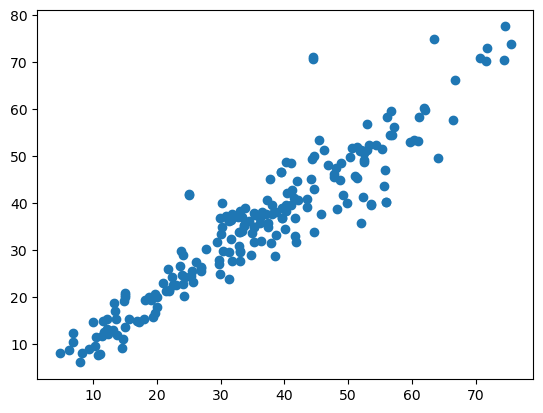

In [35]:
# モデルの評価
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')
    plt.scatter(y_test,predictions, label='Train Loss')

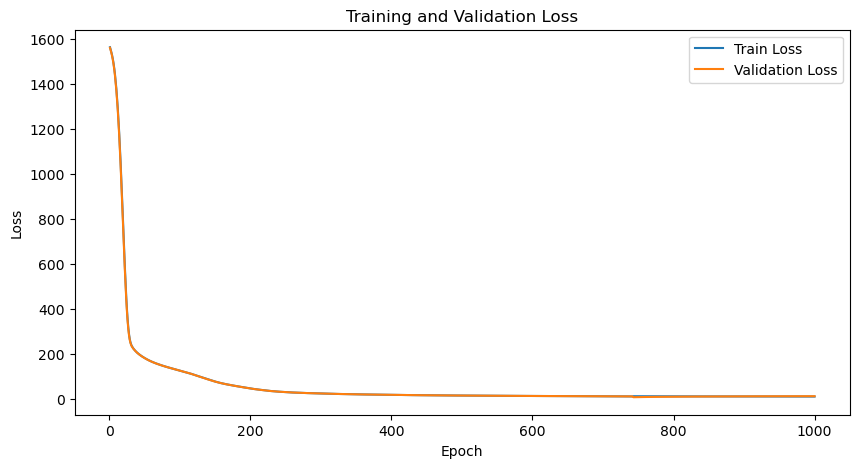

In [36]:
# 学習過程の可視化
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [37]:
# 予測結果の表示
print(predictions[:10])  # 最初の10行の予測結果を表示

tensor([[51.2648],
        [40.2434],
        [77.6552],
        [34.8918],
        [11.5905],
        [49.4556],
        [26.6076],
        [53.3687],
        [35.7287],
        [48.4994]])


In [38]:
# テストデータの最初の10行を表示
print(y_test[:10])

tensor([[52.9100],
        [55.9000],
        [74.5000],
        [35.3000],
        [10.5400],
        [44.2800],
        [23.6900],
        [45.3700],
        [37.4000],
        [48.8500]])


In [39]:
test(d)

NameError: name 'test' is not defined